# Time Series Clustering

## 0. 데이터 불러오기

In [ ]:
!pip install tslearn

     |████████████████████████████████| 798kB 3.9MB/s 


In [ ]:
import numpy as np
import pandas as pd
import datetime
from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

rc('font', family='MalgunGothic')
plt.rcParams['axes.unicode_minus'] = False

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score

/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/기상청/데이터')

In [ ]:
data = pd.read_csv('data.csv', encoding='CP949')

In [ ]:
data.head()

,date,sex,age,big_cat,sm_cat,qty,cnt
0,20180101,F,20,식품,가공란,37,0.480964
1,20180101,F,30,식품,가공란,16,0.480964
2,20180101,F,40,식품,가공란,9,0.480964
3,20180101,F,50,식품,가공란,3,0.480964
4,20180101,M,20,식품,가공란,13,0.480964


# 2. 데이터 전처리

## 2-1. 2018년, 2019년 요일 맞추기

In [ ]:
data['year'] = data['date'].progress_apply(lambda x :str(x)[:4])
buy_2018 = data[data.year=='2018'][['date', 'sex', 'age', 'big_cat', 'sm_cat', 'qty']]
buy_2019 = data[data.year=='2019'][['date', 'sex', 'age', 'big_cat', 'sm_cat', 'qty']]
buy_2018['date'] = buy_2018['date'].progress_apply(lambda x : pd.to_datetime(str(x), format='%Y%m%d'))
buy_2019['date'] = buy_2019['date'].progress_apply(lambda x : pd.to_datetime(str(x), format='%Y%m%d'))
buy_2018.shape, buy_2019.shape

((1005487, 6), (1051412, 6))

In [ ]:
buy_2018["date"] = buy_2018["date"] + datetime.timedelta(days=-1)
buy_2018["date"] = buy_2018["date"].progress_apply(lambda x : x.replace(year=2018, month=12, day=31) if x==datetime.date(2017, 12, 31) else x)

In [ ]:
buy_2018_cat = buy_2018.groupby(['date', 'sm_cat']).sum('qty').reset_index()[['date', 'sm_cat', 'qty']]
buy_2019_cat = buy_2019.groupby(['date', 'sm_cat']).sum('qty').reset_index()[['date', 'sm_cat', 'qty']]
buy_2018_cat["date"] = buy_2018_cat["date"].progress_apply(lambda x : str(x)[5:10])
buy_2019_cat["date"] = buy_2019_cat["date"].progress_apply(lambda x : str(x)[5:10])
buy_2018_ts = pd.pivot_table(buy_2018_cat, index="sm_cat", columns="date", values="qty")
buy_2019_ts = pd.pivot_table(buy_2019_cat, index="sm_cat", columns="date", values="qty")
buy_2018_ts.shape, buy_2019_ts.shape

((383, 365), (383, 365))

## 2-2. 결측값

In [ ]:
buy_2018_ts = buy_2018_ts.fillna(0)
buy_2019_ts = buy_2019_ts.fillna(0)

## 2-3. 평균

In [ ]:
buy_ts = (buy_2018_ts + buy_2019_ts)/2

## 2-4. 데이터 정규화

In [ ]:
avg_lst = []; std_lst = []
for idx, row in tqdm(buy_ts.iterrows()):
    avg_lst.append(row.mean())
    std_lst.append(row.std())

In [ ]:
buy_ts['avg'] = avg_lst
buy_ts['std'] = std_lst
buy_ts.head()

date,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,01-10,01-11,01-12,01-13,01-14,01-15,01-16,01-17,01-18,01-19,01-20,01-21,01-22,01-23,01-24,01-25,01-26,01-27,01-28,01-29,01-30,01-31,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,...,11-24,11-25,11-26,11-27,11-28,11-29,11-30,12-01,12-02,12-03,12-04,12-05,12-06,12-07,12-08,12-09,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31,avg,std
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가공란,197.0,200.5,158.5,128.0,147.5,164.0,212.5,234.0,250.0,185.5,159.0,108.0,184.0,223.0,190.0,175.0,410.0,151.5,104.0,146.0,193.0,180.0,165.5,131.0,188.0,100.0,119.5,199.0,145.0,353.5,112.5,74.5,67.5,74.0,129.0,74.0,105.5,159.5,139.5,131.5,...,274.0,266.5,221.0,207.5,177.0,341.0,112.5,145.0,301.5,196.0,199.5,172.0,122.5,89.5,121.5,195.5,240.5,209.5,134.5,135.5,78.5,118.0,245.0,175.5,193.0,188.5,124.0,80.0,119.5,182.0,141.0,316.5,255.0,262.0,114.0,138.0,203.5,151.0,183.620548,67.424066
가스온수기,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,0.0,0.5,0.0,1.0,0.5,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.5,1.0,1.0,0.0,0.0,...,0.0,0.5,0.0,0.5,0.5,0.0,1.5,0.5,0.0,0.5,0.0,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.5,0.5,0.5,0.0,1.5,0.5,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.206849,0.359842
가열식 가습기,24.5,19.5,21.0,19.0,11.5,17.0,16.5,18.5,21.5,15.0,11.0,10.0,9.0,10.0,12.0,8.0,8.5,8.0,4.5,7.0,7.0,9.5,11.5,10.5,11.0,4.0,8.0,14.5,12.0,10.0,7.5,5.5,3.5,5.0,4.5,3.5,5.0,8.0,9.0,4.0,...,16.0,24.0,20.5,26.5,19.0,17.0,14.5,12.0,25.5,32.0,26.5,30.5,49.0,24.0,26.0,40.0,36.0,30.5,27.5,23.5,15.5,18.5,29.5,18.5,18.0,24.5,19.5,12.0,19.0,22.0,17.0,15.5,17.0,25.5,14.5,15.0,17.0,11.0,6.782192,8.445435
가자미,19.0,26.0,20.0,33.0,15.5,23.5,43.0,28.0,37.5,42.5,19.5,29.5,26.0,30.0,60.0,18.5,23.5,28.0,8.0,46.5,48.0,43.0,46.0,24.0,49.0,15.5,20.5,58.0,22.5,22.0,20.0,14.5,17.0,12.5,25.0,41.0,17.0,28.5,23.5,18.5,...,17.0,26.5,26.0,23.0,23.5,28.5,15.0,22.0,52.5,35.0,42.0,26.0,21.5,17.0,24.5,21.5,21.5,27.5,50.5,23.5,20.5,23.0,28.5,26.0,30.5,29.0,30.0,20.0,24.0,20.0,15.5,30.0,22.0,46.0,33.5,23.5,31.0,39.0,26.532877,13.565228
갈비/찜/바비큐용 돈육,15.0,11.0,13.0,9.0,16.5,10.0,13.5,17.0,17.0,13.5,14.0,21.5,20.0,19.0,16.5,15.5,21.5,13.0,11.5,13.0,7.0,17.5,15.0,23.0,18.0,9.5,21.5,25.0,10.0,17.0,9.0,10.0,14.5,12.0,17.0,18.0,17.5,15.0,21.5,17.0,...,21.5,30.5,16.0,19.0,18.5,18.5,17.0,19.5,14.0,25.5,31.5,27.5,18.0,23.0,17.5,19.5,15.5,21.0,20.0,22.0,23.0,26.0,32.0,26.0,24.5,23.0,17.0,17.0,32.0,24.0,25.5,28.0,19.0,13.5,28.0,22.5,26.0,29.5,18.553425,6.656652


In [ ]:
for i in tqdm(range(len(buy_ts))):
    for j in range(365):
        buy_ts.iloc[i,j] = (buy_ts.iloc[i,j] - buy_ts.iloc[i,365])/buy_ts.iloc[i,366]

In [ ]:
buy_ts = buy_ts.drop(['avg','std'], axis=1)

In [ ]:
buy_ts.head()

date,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,01-10,01-11,01-12,01-13,01-14,01-15,01-16,01-17,01-18,01-19,01-20,01-21,01-22,01-23,01-24,01-25,01-26,01-27,01-28,01-29,01-30,01-31,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,...,11-22,11-23,11-24,11-25,11-26,11-27,11-28,11-29,11-30,12-01,12-02,12-03,12-04,12-05,12-06,12-07,12-08,12-09,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가공란,0.198437,0.250348,-0.372575,-0.824936,-0.535722,-0.291002,0.428326,0.747203,0.984507,0.027875,-0.365160,-1.121566,0.005628,0.584056,0.094617,-0.127856,3.357547,-0.476396,-1.180892,-0.557969,0.139111,-0.053698,-0.268755,-0.780442,0.064954,-1.240218,-0.951004,0.228100,-0.572801,2.519567,-1.054824,-1.618421,-1.722242,-1.625837,-0.810105,-1.625837,-1.158645,-0.357744,-0.654374,-0.773026,...,-0.810105,-1.240218,1.340463,1.229227,0.554393,0.354168,-0.098193,2.334173,-1.054824,-0.572801,1.748329,0.183606,0.235516,-0.172350,-0.906509,-1.395949,-0.921341,0.176190,0.843608,0.383831,-0.728531,-0.713700,-1.559095,-0.973251,0.910349,-0.120440,0.139111,0.072370,-0.884262,-1.536848,-0.951004,-0.024035,-0.632127,1.970802,1.058664,1.162485,-1.032577,-0.676621,0.294842,-0.483812
가스온수기,-0.574834,0.814666,-0.574834,-0.574834,-0.574834,-0.574834,0.814666,-0.574834,0.814666,0.814666,-0.574834,0.814666,-0.574834,2.204167,0.814666,2.204167,-0.574834,0.814666,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,2.204167,0.814666,-0.574834,-0.574834,2.204167,-0.574834,-0.574834,-0.574834,0.814666,2.204167,2.204167,-0.574834,-0.574834,...,-0.574834,2.204167,-0.574834,0.814666,-0.574834,0.814666,0.814666,-0.574834,3.593667,0.814666,-0.574834,0.814666,-0.574834,-0.574834,0.814666,0.814666,-0.574834,0.814666,-0.574834,-0.574834,0.814666,0.814666,0.814666,-0.574834,3.593667,0.814666,0.814666,0.814666,0.814666,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,0.814666,-0.574834,-0.574834,-0.574834,-0.574834
가열식 가습기,2.097915,1.505880,1.683490,1.446676,0.558622,1.209862,1.150658,1.387472,1.742694,0.973047,0.499419,0.381012,0.262604,0.381012,0.617826,0.144197,0.203401,0.144197,-0.270228,0.025790,0.025790,0.321808,0.558622,0.440215,0.499419,-0.329431,0.144197,0.913844,0.617826,0.381012,0.084994,-0.151821,-0.388635,-0.211024,-0.270228,-0.388635,-0.211024,0.144197,0.262604,-0.329431,...,1.683490,0.617826,1.091455,2.038712,1.624287,2.334730,1.446676,1.209862,0.913844,0.617826,2.216323,2.985969,2.334730,2.808358,4.998891,2.038712,2.275526,3.933227,3.459598,2.808358,2.453137,1.979508,1.032251,1.387472,2.689951,1.387472,1.328269,2.097915,1.505880,0.617826,1.446676,1.801898,1.209862,1.032251,1.209862,2.216323,0.913844,0.973047,1.209862,0.499419
가자미,-0.555308,-0.039283,-0.481590,0.476743,-0.813320,-0.223577,1.213922,0.108153,0.808473,1.177063,-0.518449,0.218730,-0.039283,0.255589,2.467126,-0.592167,-0.223577,0.108153,-1.366205,1.471934,1.582511,1.213922,1.435075,-0.186718,1.656229,-0.813320,-0.444731,2.319690,-0.297295,-0.334154,-0.481590,-0.887038,-0.702744,-1.034474,-0.113000,1.066486,-0.702744,0.145012,-0.223577,-0.592167,...,-0.518449,-0.776461,-0.702744,-0.002424,-0.039283,-0.260436,-0.223577,0.145012,-0.850179,-0.334154,1.914242,0.624178,1.140204,-0.039283,-0.371013,-0.702744,-0.149859,-0.371013,-0.371013,0.071294,1.766806,-0.223577,-0.444731,-0.260436,0.145012,-0.039283,0.292448,0.181871,0.255589,-0.481590,-0.186718,-0.481590,-0.813320,0.255589,-0.334154,1.435075,0.513602,-0.223577,0.329307,0.919050
갈비/찜/바비큐용 돈육,-0.533816,-1.134718,-0.834267,-1.435170,-0.308477,-1.284944,-0.759154,-0.233364,-0.233364,-0.759154,-0.684041,0.442651,0.217313,0.067087,-0.308477,-0.458703,0.442651,-0.834267,-1.059605,-0.834267,-1.735621,-0.158251,-0.533816,0.667990,-0.083139,-1.360057,0.442651,0.968441,-1.284944,-0.233364,-1.435170,-1.284944,-0.608928,-0.984493,-0.23336

# 3. Time Series Clustering

* DTW

### 3-1. 최적의 k

In [ ]:
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in tqdm(range(2, 7)):
        ts_clustering = TimeSeriesKMeans(n_clusters=i, max_iter=param_max_iter, random_state=1234, metric = 'dtw')
        ts_clustering.fit(data)
        distortions.append(ts_clustering.inertia_)
    return distortions

In [ ]:
# 하나에 10분
distortions = visualize_elbowmethod(buy_ts)

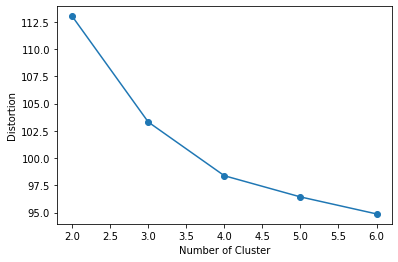

In [ ]:
plt.plot(range(2, 7), distortions, marker='o')
plt.xlabel('Number of Cluster')
plt.ylabel('Distortion')
plt.show()

* elbow point = 4

### 3-2. Clustering

In [ ]:
# 1시간 30분
%%time
model_dtw = TimeSeriesKMeans(n_clusters=4, init='random', n_init=10, max_iter=300, random_state=1234, metric = 'dtw').fit(buy_ts)

CPU times: user 1h 17min 23s, sys: 12min 36s, total: 1h 29min 59s
Wall time: 1h 18min 8s


In [ ]:
result_dtw = model_dtw.predict(buy_ts)

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 383 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


In [ ]:
buy_ts['cluster'] = result_dtw

In [ ]:
buy_ts.head()

date,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,01-10,01-11,01-12,01-13,01-14,01-15,01-16,01-17,01-18,01-19,01-20,01-21,01-22,01-23,01-24,01-25,01-26,01-27,01-28,01-29,01-30,01-31,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,...,11-23,11-24,11-25,11-26,11-27,11-28,11-29,11-30,12-01,12-02,12-03,12-04,12-05,12-06,12-07,12-08,12-09,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31,cluster
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가공란,0.198437,0.250348,-0.372575,-0.824936,-0.535722,-0.291002,0.428326,0.747203,0.984507,0.027875,-0.365160,-1.121566,0.005628,0.584056,0.094617,-0.127856,3.357547,-0.476396,-1.180892,-0.557969,0.139111,-0.053698,-0.268755,-0.780442,0.064954,-1.240218,-0.951004,0.228100,-0.572801,2.519567,-1.054824,-1.618421,-1.722242,-1.625837,-0.810105,-1.625837,-1.158645,-0.357744,-0.654374,-0.773026,...,-1.240218,1.340463,1.229227,0.554393,0.354168,-0.098193,2.334173,-1.054824,-0.572801,1.748329,0.183606,0.235516,-0.172350,-0.906509,-1.395949,-0.921341,0.176190,0.843608,0.383831,-0.728531,-0.713700,-1.559095,-0.973251,0.910349,-0.120440,0.139111,0.072370,-0.884262,-1.536848,-0.951004,-0.024035,-0.632127,1.970802,1.058664,1.162485,-1.032577,-0.676621,0.294842,-0.483812,3
가스온수기,-0.574834,0.814666,-0.574834,-0.574834,-0.574834,-0.574834,0.814666,-0.574834,0.814666,0.814666,-0.574834,0.814666,-0.574834,2.204167,0.814666,2.204167,-0.574834,0.814666,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,2.204167,0.814666,-0.574834,-0.574834,2.204167,-0.574834,-0.574834,-0.574834,0.814666,2.204167,2.204167,-0.574834,-0.574834,...,2.204167,-0.574834,0.814666,-0.574834,0.814666,0.814666,-0.574834,3.593667,0.814666,-0.574834,0.814666,-0.574834,-0.574834,0.814666,0.814666,-0.574834,0.814666,-0.574834,-0.574834,0.814666,0.814666,0.814666,-0.574834,3.593667,0.814666,0.814666,0.814666,0.814666,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,0.814666,-0.574834,-0.574834,-0.574834,-0.574834,3
가열식 가습기,2.097915,1.505880,1.683490,1.446676,0.558622,1.209862,1.150658,1.387472,1.742694,0.973047,0.499419,0.381012,0.262604,0.381012,0.617826,0.144197,0.203401,0.144197,-0.270228,0.025790,0.025790,0.321808,0.558622,0.440215,0.499419,-0.329431,0.144197,0.913844,0.617826,0.381012,0.084994,-0.151821,-0.388635,-0.211024,-0.270228,-0.388635,-0.211024,0.144197,0.262604,-0.329431,...,0.617826,1.091455,2.038712,1.624287,2.334730,1.446676,1.209862,0.913844,0.617826,2.216323,2.985969,2.334730,2.808358,4.998891,2.038712,2.275526,3.933227,3.459598,2.808358,2.453137,1.979508,1.032251,1.387472,2.689951,1.387472,1.328269,2.097915,1.505880,0.617826,1.446676,1.801898,1.209862,1.032251,1.209862,2.216323,0.913844,0.973047,1.209862,0.499419,0
가자미,-0.555308,-0.039283,-0.481590,0.476743,-0.813320,-0.223577,1.213922,0.108153,0.808473,1.177063,-0.518449,0.218730,-0.039283,0.255589,2.467126,-0.592167,-0.223577,0.108153,-1.366205,1.471934,1.582511,1.213922,1.435075,-0.186718,1.656229,-0.813320,-0.444731,2.319690,-0.297295,-0.334154,-0.481590,-0.887038,-0.702744,-1.034474,-0.113000,1.066486,-0.702744,0.145012,-0.223577,-0.592167,...,-0.776461,-0.702744,-0.002424,-0.039283,-0.260436,-0.223577,0.145012,-0.850179,-0.334154,1.914242,0.624178,1.140204,-0.039283,-0.371013,-0.702744,-0.149859,-0.371013,-0.371013,0.071294,1.766806,-0.223577,-0.444731,-0.260436,0.145012,-0.039283,0.292448,0.181871,0.255589,-0.481590,-0.186718,-0.481590,-0.813320,0.255589,-0.334154,1.435075,0.513602,-0.223577,0.329307,0.919050,3
갈비/찜/바비큐용 돈육,-0.533816,-1.134718,-0.834267,-1.435170,-0.308477,-1.284944,-0.759154,-0.233364,-0.233364,-0.759154,-0.684041,0.442651,0.217313,0.067087,-0.308477,-0.458703,0.442651,-0.834267,-1.059605,-0.834267,-1.735621,-0.158251,-0.533816,0.667990,-0.083139,-1.360057,0.442651,0.968441,-1.284944,-0.233364,-1.435170,-1.284944,-0.608928,-0.984493,-0.233364,-0.083139,-0.158251,-0.5338

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.p

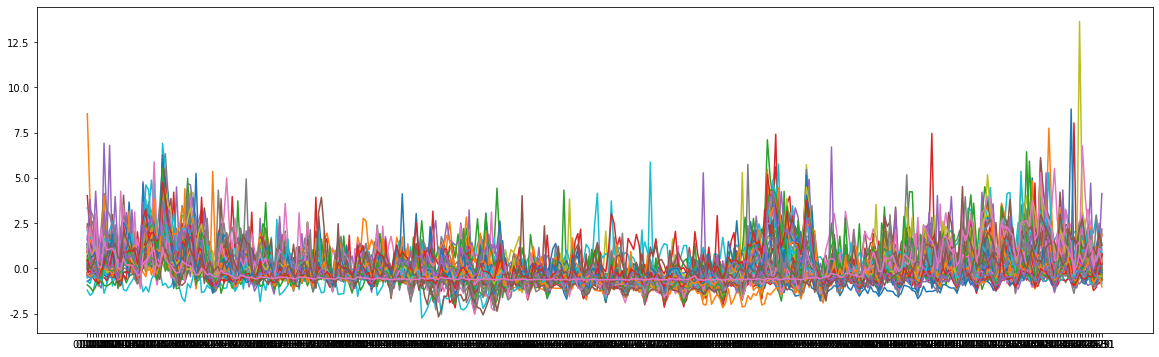

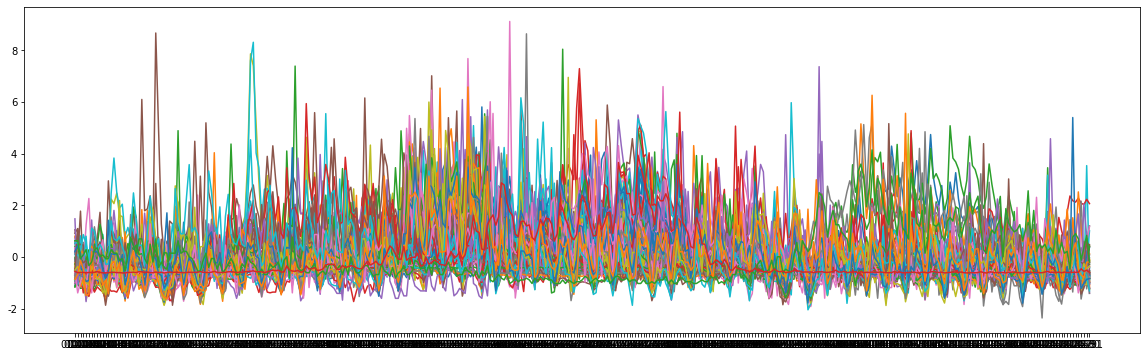

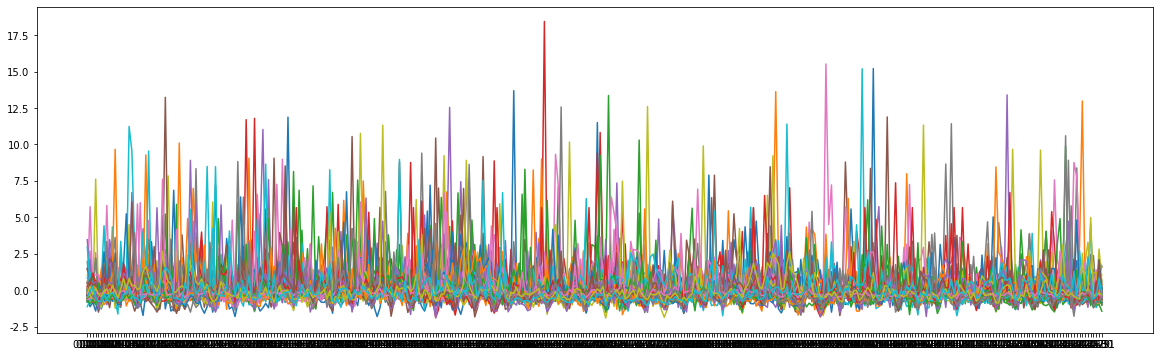

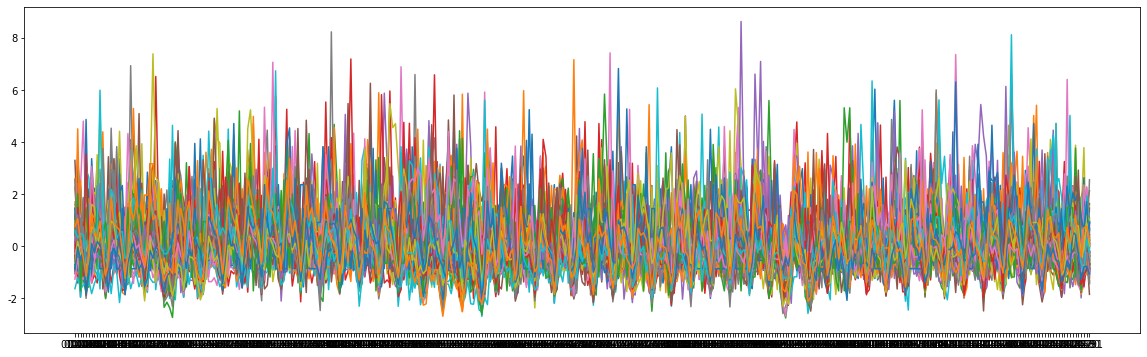

In [ ]:
for i in range(4):
    clusters = buy_ts[buy_ts['cluster']==i]
    clusters.drop(['cluster'], axis=1, inplace=True)
    plt.figure(figsize=(20,6))
    plt.plot(clusters.T)
    plt.show

<function matplotlib.pyplot.show>

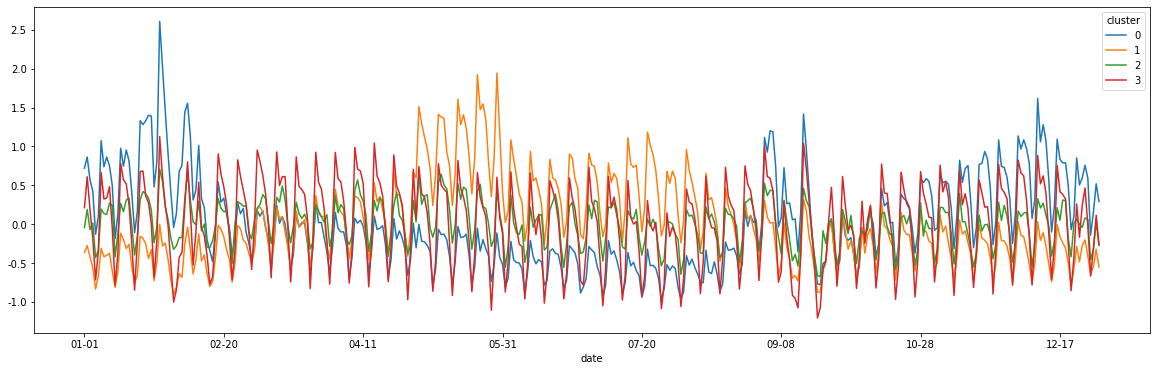

In [ ]:
plt.rcParams["figure.figsize"]=(20,6)
buy_ts.groupby(['cluster']).mean().T.plot()
plt.show

In [ ]:
data_final = buy_ts.reset_index()

In [ ]:
data_final.to_csv('/content/drive/MyDrive/기상청/데이터/cluster_dtw_match_day.csv', encoding='CP949', index = False)

In [ ]:
# 확인
pd.read_csv('/content/drive/MyDrive/기상청/데이터/cluster_dtw_match_day.csv', encoding='CP949')

,sm_cat,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,01-10,01-11,01-12,01-13,01-14,01-15,01-16,01-17,01-18,01-19,01-20,01-21,01-22,01-23,01-24,01-25,01-26,01-27,01-28,01-29,01-30,01-31,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,...,11-23,11-24,11-25,11-26,11-27,11-28,11-29,11-30,12-01,12-02,12-03,12-04,12-05,12-06,12-07,12-08,12-09,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31,cluster
0,가공란,0.198437,0.250348,-0.372575,-0.824936,-0.535722,-0.291002,0.428326,0.747203,0.984507,0.027875,-0.365160,-1.121566,0.005628,0.584056,0.094617,-0.127856,3.357547,-0.476396,-1.180892,-0.557969,0.139111,-0.053698,-0.268755,-0.780442,0.064954,-1.240218,-0.951004,0.228100,-0.572801,2.519567,-1.054824,-1.618421,-1.722242,-1.625837,-0.810105,-1.625837,-1.158645,-0.357744,-0.654374,...,-1.240218,1.340463,1.229227,0.554393,0.354168,-0.098193,2.334173,-1.054824,-0.572801,1.748329,0.183606,0.235516,-0.172350,-0.906509,-1.395949,-0.921341,0.176190,0.843608,0.383831,-0.728531,-0.713700,-1.559095,-0.973251,0.910349,-0.120440,0.139111,0.072370,-0.884262,-1.536848,-0.951004,-0.024035,-0.632127,1.970802,1.058664,1.162485,-1.032577,-0.676621,0.294842,-0.483812,3
1,가스온수기,-0.574834,0.814666,-0.574834,-0.574834,-0.574834,-0.574834,0.814666,-0.574834,0.814666,0.814666,-0.574834,0.814666,-0.574834,2.204167,0.814666,2.204167,-0.574834,0.814666,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,2.204167,0.814666,-0.574834,-0.574834,2.204167,-0.574834,-0.574834,-0.574834,0.814666,2.204167,2.204167,-0.574834,...,2.204167,-0.574834,0.814666,-0.574834,0.814666,0.814666,-0.574834,3.593667,0.814666,-0.574834,0.814666,-0.574834,-0.574834,0.814666,0.814666,-0.574834,0.814666,-0.574834,-0.574834,0.814666,0.814666,0.814666,-0.574834,3.593667,0.814666,0.814666,0.814666,0.814666,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,-0.574834,0.814666,-0.574834,-0.574834,-0.574834,-0.574834,3
2,가열식 가습기,2.097915,1.505880,1.683490,1.446676,0.558622,1.209862,1.150658,1.387472,1.742694,0.973047,0.499419,0.381012,0.262604,0.381012,0.617826,0.144197,0.203401,0.144197,-0.270228,0.025790,0.025790,0.321808,0.558622,0.440215,0.499419,-0.329431,0.144197,0.913844,0.617826,0.381012,0.084994,-0.151821,-0.388635,-0.211024,-0.270228,-0.388635,-0.211024,0.144197,0.262604,...,0.617826,1.091455,2.038712,1.624287,2.334730,1.446676,1.209862,0.913844,0.617826,2.216323,2.985969,2.334730,2.808358,4.998891,2.038712,2.275526,3.933227,3.459598,2.808358,2.453137,1.979508,1.032251,1.387472,2.689951,1.387472,1.328269,2.097915,1.505880,0.617826,1.446676,1.801898,1.209862,1.032251,1.209862,2.216323,0.913844,0.973047,1.209862,0.499419,0
3,가자미,-0.555308,-0.039283,-0.481590,0.476743,-0.813320,-0.223577,1.213922,0.108153,0.808473,1.177063,-0.518449,0.218730,-0.039283,0.255589,2.467126,-0.592167,-0.223577,0.108153,-1.366205,1.471934,1.582511,1.213922,1.435075,-0.186718,1.656229,-0.813320,-0.444731,2.319690,-0.297295,-0.334154,-0.481590,-0.887038,-0.702744,-1.034474,-0.113000,1.066486,-0.702744,0.145012,-0.223577,...,-0.776461,-0.702744,-0.002424,-0.039283,-0.260436,-0.223577,0.145012,-0.850179,-0.334154,1.914242,0.624178,1.140204,-0.039283,-0.371013,-0.702744,-0.149859,-0.371013,-0.371013,0.071294,1.766806,-0.223577,-0.444731,-0.260436,0.145012,-0.039283,0.292448,0.181871,0.255589,-0.481590,-0.186718,-0.481590,-0.813320,0.255589,-0.334154,1.435075,0.513602,-0.223577,0.329307,0.919050,3
4,갈비/찜/바비큐용 돈육,-0.533816,-1.134718,-0.834267,-1.435170,-0.308477,-1.284944,-0.759154,-0.233364,-0.233364,-0.759154,-0.684041,0.442651,0.217313,0.067087,-0.308477,-0.458703,0.442651,-0.834267,-1.059605,-0.834267,-1.735621,-0.158251,-0.533816,0.667990,-0.083139,-1.360057,0.442651,0.968441,-1.284944,-0.233364,-1.435170,-1.284944,-0.608928,-0.984493,-0.233364,-0.083139,-0.158251,-0.533816,0.442651,...,-0.083139,0.442651,1.794682,-0.383590,0.067087,-0.008026,-0.008026,-0.233364,0.142200,-0.684041,1.043554,

In [ ]:
pd.set_option('display.max_rows', 2000)

In [ ]:
for i in range(4):
    print("클러스터",i)
    print("소분류 개수: ",data_final[data_final['cluster']==i]['sm_cat'].shape[0])
    print(data_final[data_final['cluster']==i]['sm_cat'])
    print('======='*10)

클러스터 0
소분류 개수:  67
2            가열식 가습기
8         감귤/한라봉/오렌지
10              감말랭이
21            건어물 멸치
24            건어물 황태
31             견과류 밤
40               곡물차
43            곶감/반건시
46              과일세트
51              굴 생물
52             굴비/조기
61         기초 화장용 로션
65      기초 화장용 오일/앰플
66         기초 화장용 크림
74           난방용 열풍기
78             남성 세트
99            대게/킹크랩
102           도라지/더덕
103              돈풍기
104            돼지 곱창
107      딸기/복분자/블루베리
109            라디에이터
133           바디 보습제
134            바디 세트
165          복합식 가습기
189       색조 메이크업 립밤
190      색조 메이크업 립스틱
199    색조 메이크업 아이섀도우
201              생선류
213        소고기 등심/안심
216            수산 생물
230              시금치
240             양념우육
249             에어워셔
260               옥돔
265              온풍기
271              유자차
272           유제품 음료
273              율무차
278         인삼/수삼/산삼
280              입욕제
281          자연식 가습기
287            전기온수기
289            전복 생물
290              전통주
295               조개
298           차